# Piecewise-stationary multi-armed bandit

The piecewise-stationary or switching bandits are a variant of dynamic multi-armed bandits in which reward probability $p_{t, l}$ changes suddenly but is otherwise constant. We can express the dynamics of reward probabilities as 
\begin{equation}
    p_{t, l} \sim \left\{ \begin{array}{cc}
        Beta(1, 1) & \textrm{for } j_{t-1} = 1  \\
        \delta(p_{t,l} - p_{t-1, l}) & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $Beta(1, 1)$ denotes beta (uniform) distribution, and $\delta(x)$ Dirac's delta function. Similarly, we will express the transition probability of the change point variable $j_{t}$ as
\begin{equation}
    p(j_{t}=j|j_{t-1}) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1} = 1  \\
        \rho^{j}(1-\rho)^{1-j} & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $\delta_{j,0} = 1$ for $j=0$. Note than when a change point occurs, the reward probabilities on all armes change toghether. In practice, one can also consider other scenarios (depending on the application), e.g. only one or more arms change at each break point.

Let us first implement the generative process of the switching bandits.

In [16]:
import numpyro as npyro
import numpyro.distributions as dist

import jax.numpy as np
from jax import random, lax, nn, ops

K = 3 # do not change this for now as everything would fail
rho = .01

log_pj_j = np.log(np.array([[1 - rho, rho], [1, 0]]))

def process(t, choices, states, rng_key):
    probs, changes = states
    
    rng_key, _rng_key = random.split(rng_key)
    new_change = random.categorical(_rng_key, log_pj_j[changes])
    
    rng_key, _rng_key = random.split(rng_key)
    random_probs = random.uniform(_rng_key, shape=(K,))
    
    new_probs = np.where(new_change, random_probs, probs)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    N = choices.shape[0]
    
    return outcomes[None].repeat(N, 0), [new_probs, new_change]

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process(t, choices, states, _rng_key)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'probs': states[0], 'changes': states[1]}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(1, dtype=np.int32)]
    choices = np.zeros(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

In [17]:
sequence = simulator(process)

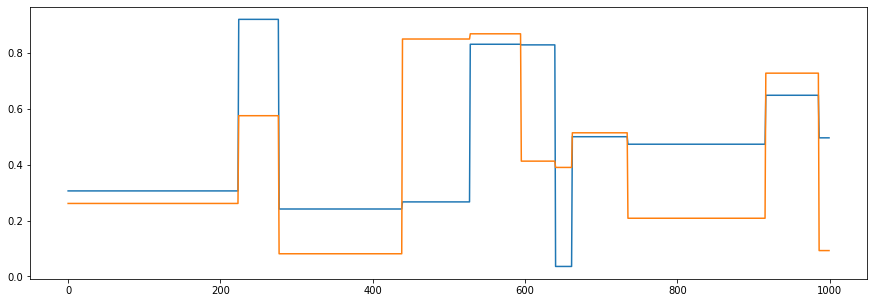

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(15, 5))
plt.plot(sequence['probs'][:, :2])

Lets assume that reward probability can have only D discrete values, for example 

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$.

Hence if we associate reward probabilities of each arm with descrete hidden states $k_{t,l}$ we can describe the whole problem as a hierarchical hidden markov model. In this case the state transition matrix is given as 

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, j_{t-1}=0) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, j_{t-1}=0) = \prod_{l=1}^K I_D$$

that is, states do not change in the absence of a change point, and

$$ p(\vec{k}_{t,l}|\vec{k}_{t-1, l}, j_{t-1}=1) = \prod_{l=1}^K p(k_{t,l}|k_{t-1,l}, j_{t-1}=1) = \prod_{l=1}^K \frac{1}{D-1} \left( J_{D} - I_D \right) $$

where $J_D$ stands for a D-dimensional matrix of ones, and $I_D$ for a D-dimensional identity matrix.

This way one can define an exact update of beliefs using Bayes rule

$$ p(\vec{k}_t, j_t|\vec{o}_{1:t}) \propto p(\vec{o}_t|\vec{k}_t)p(\vec{k}_t,j_t|\vec{o}_{1:t-1})$$

where 

$$ p(\vec{o}_t|\vec{k}_t) = \prod_{l=1}^K p(o_{t,l}|k_{t,l}) = \prod_{l=1}^K P(k_{t,l})^{o_{t,l}}\left( 1-P(k_{t,l}) \right)^{1-o_{t,l}}$$

The above observation likelihood would correspond to the case when the agent can sample outcomes from all arms at the same time. However, we are considering the case when on any trial only one arm can be sampled. We will associate a choice of an agent to sample from $l$th arm at trial $t$ with as another random variable $s_t=l$, where

$$ p(s_t|s_{t-1}, a_t) = p(s_t|a_t) = \delta_{s_t, a_t}$$
where $a_t$ denotes a choice at trial $t$. Finally, sampling from the $l$th arm corresponds with observing an outcome $o_{t,l}$ with underlying probability $p_{t,l}$ and a outcomes from all other arms with probability $1/2$, for all $m\neq l$. Hence, we can define the observation likelihood as 

$$ p(\vec{o}_t|\vec{k}_t, s_t=l) = P(k_{t,l})^{o_{t,l}}\left( 1-P(k_{t,l}) \right)^{1-o_{t,l}} \prod_{m \neq l} \frac{1}{2}^{1-o_{t,m} + o_{t,m}} $$

We will assume that the choice states $s_t$ are directly observable, hence

$$ p(o^s_t = o|s_t=l) = \delta_{o, l}$$

In [19]:
from itertools import product
D = 10
pj_j = np.exp(log_pj_j)

args = [np.eye(D)] * K
tm1 = np.einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

args = [(np.ones((D,D)) - np.eye(D))/(D-1)] * K
tm2 = np.einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

pk_kj = np.stack([tm1, tm2], 0)

po_k = np.array(list(product(np.arange(1/(2*D), 1., 1/D), repeat=K)))
po_ks = np.where(np.eye(K, dtype=np.int32)[:, None], po_k, .5)

log_po_ks = np.log(po_ks)
log_1_po_ks = np.log(1 - po_ks)

def learning(outcomes, choices, priors):
    
    pred = np.einsum('iks,ij,nik->njs', pk_kj, pj_j, priors)
        
    o = outcomes[:, None]
    lklh = np.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None] * pred
    N = choices.shape[0]
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1)
    
    return joint/norm

def thompson_selection(beliefs, rng_key):
    #Thompson sampling
    marg = np.einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, np.log(marg))
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

H_ks = - np.sum(np.nan_to_num(log_po_ks) * po_ks, -1) \
       - np.sum(np.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def efe_selection(beliefs, rng_key, gamma=10):
    # active inference
    marg = np.einsum('n...k->nk', beliefs)
    H_s = np.einsum('nk,ak->na', marg, H_ks)
    
    po_s = np.einsum('nk,ako->nao', marg, po_ks)
    log_po_s = np.nan_to_num(np.log(po_s))
    log_1_po_s = np.nan_to_num(np.log(1 - po_s))
    
    KL_s = np.sum(po_s * log_po_s + (1 - po_s) * log_1_po_s - (2 * po_s - 1), -1)
    
    G_s = KL_s + H_s
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def simulator(process, learning, action_selection, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, states = process(t, choices, states, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, states, posterior), {'outcomes': outcomes, 
                                              'probs': states[0], 
                                              'changes': states[1],
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(1, dtype=np.int32)]
    args = [np.array([0., 1.])] + [np.ones(D)/D]*K
    prior = np.einsum('j,i,l,m->jilm', *args).reshape(2, -1)[None].repeat(N, 0)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, prior), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

In [20]:
N = 20
T = 1000
sequence1 = simulator(process, learning, thompson_selection, N=N, T=T)

sequence2 = simulator(process, learning, efe_selection, N=N, T=T)

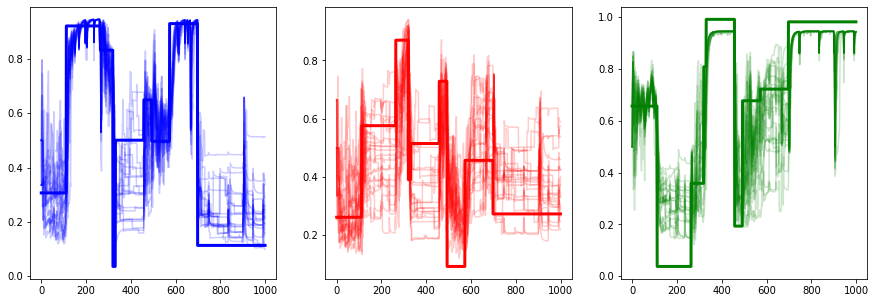

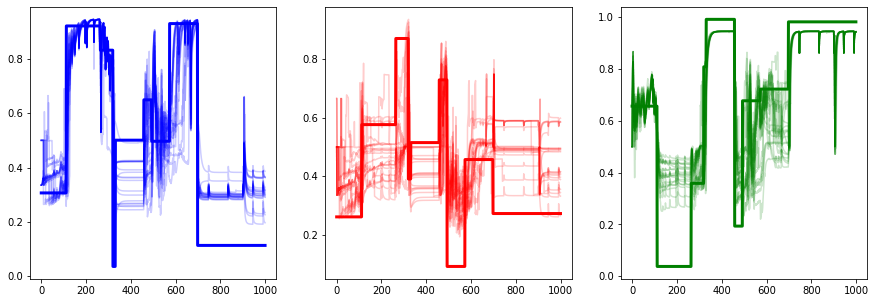

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

post = sequence1['beliefs']
post_probs = np.einsum('tnk,lko->tnlo', post.sum(-2), po_ks)
true_probs = sequence1['probs']

colours = ['b', 'r', 'g']
for k in range(K):
    axes[k].plot(post_probs[..., k, k], c=colours[k], alpha=.2)
    axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

post = sequence2['beliefs']
post_probs = np.einsum('tnk,lko->tnlo', post.sum(-2), po_ks)
true_probs = sequence1['probs']

colours = ['b', 'r', 'g']
for k in range(K):
    axes[k].plot(post_probs[..., k, k], c=colours[k], alpha=.2)
    axes[k].plot(true_probs[:, k], c=colours[k], lw=3)

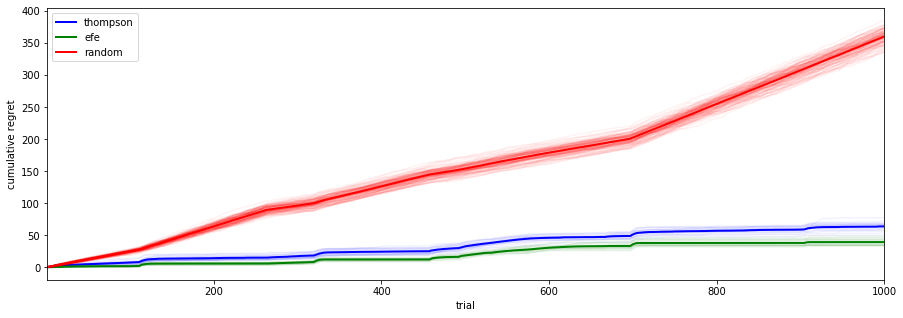

In [25]:
choices_thm = sequence1['choices']
choices_efe = sequence2['choices']

max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))
thm_probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices_thm[:, n]], (0, 1)) for n in range(N)], 0)
efe_probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices_efe[:, n]], (0, 1)) for n in range(N)], 0)

n_smpl = 100
random_choices = random.categorical(random.PRNGKey(547890), np.zeros(K), shape=(T, n_smpl))
random_probs = np.stack([lax.index_take(true_probs, [np.arange(T), random_choices[:, n]], (0, 1)) for n in range(n_smpl)], 0)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
regret = np.cumsum(max_probs - thm_probs, -1).T
plt.plot(regret, 'b', alpha=.05);
plt.plot(regret.mean(-1), 'b', label='thompson', lw=2)

regret = np.cumsum(max_probs - efe_probs, -1).T
plt.plot(regret, 'g', alpha=.05);
plt.plot(regret.mean(-1), 'g', label='efe', lw=2)

regret = np.cumsum(max_probs - random_probs, -1).T
plt.plot(regret, 'r', alpha=.05);
plt.plot(regret.mean(-1), 'r', label='random', lw=2)

plt.xlim(1, T)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend()

fig.savefig('cum_reg_piecewise1.png', dpi=300)

Above we have assumed that the agent already knows the change point probability, however in general this will be a hidden quantity for the agent. Here we will add another level of the hierarchy in which agent infers the change point probability also. Similar to likelihoods we can discretise the change point probability $\rho$ and assume that 

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

We will associate different possible values with descrete hidden states $r_t$, and express the change point transition matrix as 

\begin{equation}
    p(j_{t}=j|j_{t-1}, r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1,l} = 1  \\
        \rho_r^{j}(1-\rho_r)^{1-j} & \textrm{for } j_{t-1,l} = 0
    \end{array}
    \right.
\end{equation}

and the $r_t$ transition probabability as a 1D random walk

\begin{equation}
    p(r_t=q|r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{q, r} & \textrm{with Pr. } 1 - \kappa  \\
        \delta_{q, r + 1} & \textrm{with Pr. } \frac{\kappa}{2} \\
        \delta_{q, r - 1} & \textrm{with Pr. } \frac{\kappa}{2}
    \end{array}
    \right.
\end{equation}

The belief update becomes

$$ p(\vec{k}_t, j_t, r_t|\vec{o}_{1:t}, a_{1:t}) \propto p(\vec{o}_t|\vec{k}_t, a_t)p(\vec{k}_t,j_t, r_t|o_{1:t-1})$$

where we have marginlised out $s_t$. We will assume a priory a bias toward small change probabilities, hence 

$$ p(r_0 = r) \propto e^{-\lambda r} $$

In [30]:
M = 50

kappa = 1e-6
pr_r = (1 - kappa) * np.eye(M) + kappa * (np.diag(np.ones(M-1), 1) + np.diag(np.ones(M-1), -1))/2
pr_r = ops.index_update(pr_r, ops.index[[0, -1], [1, -2]], kappa)

rho = np.arange(1/(2*M), 1, 1/M)
stay = np.stack([1 - rho, rho], -1)
change = np.array([1., 0.])[None].repeat(M, -2)
pj_jr = np.stack([stay, change], -2)

def learning(outcomes, choices, priors):
    N = priors.shape[0]
    pred = np.einsum('iks,rij,rq,nrik->nqjs', pk_kj, pj_jr, pr_r, priors)
    
    o = outcomes[:, None]
    lklh = np.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None, None] * pred
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1, 1)
    
    return joint/norm

def simulator(process, learning, action_selection, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, states = process(t, choices, states, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, states, posterior), {'outcomes': outcomes, 
                                              'probs': states[0], 
                                              'changes': states[1],
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(1, dtype=np.int32)]
    args = [np.exp(- 1 * np.arange(M)), np.array([0., 1.])] + [np.ones(D)/D]*K
    prior = np.einsum('i,j,k,l,m->ijklm', *args).reshape(M, 2, -1)[None].repeat(N, 0)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, prior), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

In [31]:
N = 10
T = 1000
sequence1 = simulator(process, learning, thompson_selection, N=N, T=T)

sequence2 = simulator(process, learning, efe_selection, N=N, T=T)

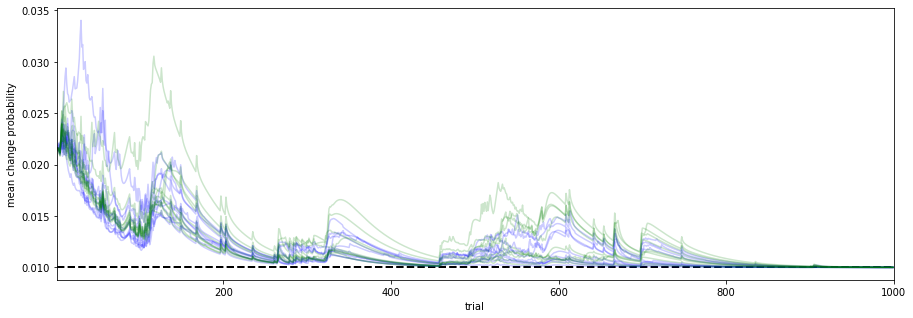

In [34]:
post = [sequence1['beliefs'], sequence2['beliefs']]

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for p, c in zip(post, ['b', 'g']):
    marg = p.reshape(T, N, M, -1).sum(-1)
    prob = np.sum(marg * rho, -1)
    
    plt.plot(prob, c, alpha=.2)

plt.hlines(.01, 1, T, 'k', lw=2, linestyle='--')
plt.xlabel('trial')
plt.ylabel('mean change probability')
plt.xlim([1, T])
fig.savefig('change_prob.png', dpi=300)

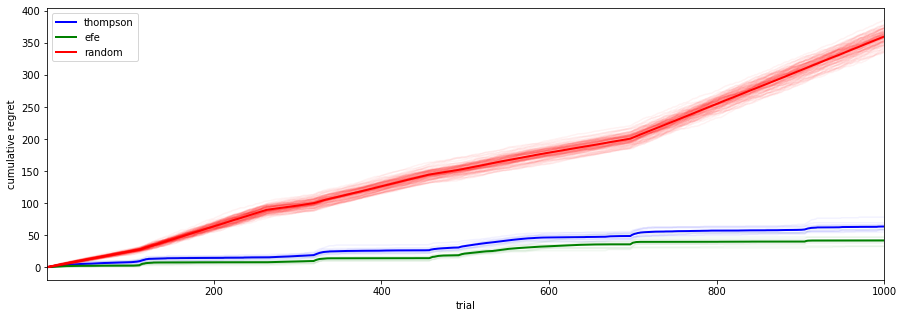

In [33]:
true_probs = sequence1['probs']
choices_thm = sequence1['choices']
choices_efe = sequence2['choices']

max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))
thm_probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices_thm[:, n]], (0, 1)) for n in range(N)], 0)
efe_probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices_efe[:, n]], (0, 1)) for n in range(N)], 0)

n_smpl = 100
random_choices = random.categorical(random.PRNGKey(547890), np.zeros(K), shape=(T, n_smpl))
random_probs = np.stack([lax.index_take(true_probs, [np.arange(T), random_choices[:, n]], (0, 1)) for n in range(n_smpl)], 0)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
regret = np.cumsum(max_probs - thm_probs, -1).T
plt.plot(regret, 'b', alpha=.05);
plt.plot(regret.mean(-1), 'b', label='thompson', lw=2)

regret = np.cumsum(max_probs - efe_probs, -1).T
plt.plot(regret, 'g', alpha=.05);
plt.plot(regret.mean(-1), 'g', label='efe', lw=2)

regret = np.cumsum(max_probs - random_probs, -1).T
plt.plot(regret, 'r', alpha=.05);
plt.plot(regret.mean(-1), 'r', label='random', lw=2)

plt.xlim(1, T)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend()

fig.savefig('cum_reg_piecewise2.png', dpi=300)